In [1]:
import torch
import torchvision
import PIL
import os
from matplotlib import pyplot as plt
import cv2
import random
import warnings
import timm
from torch import nn
import numpy as np
from tqdm import tqdm_notebook
from torchvision.models import mobilenet_v3_small
from torchsummary import summary


warnings.filterwarnings('ignore')

device='cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using: {device}')


Using: cuda


In [2]:
model=mobilenet_v3_small(weights='DEFAULT')
model.classifier[3]=nn.Linear(in_features=1024,out_features=2,bias=True)

In [3]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [4]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,src):
        self.src=src
        self.images=os.listdir(src)
        self.transforms=torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                                       torchvision.transforms.CenterCrop((224,224))])
    
    def __len__(self):
        return len(self.images)


    def __getitem__(self,idx):
        img=cv2.imread(self.src+"/"+self.images[idx])
          
        pixelize=random.randint(0,1)

        
        t_lower = 50  # Lower Threshold 
        t_upper = 150  # Upper threshold 
        '''
        edge = cv2.Canny(img, t_lower, t_upper) 
        '''
        
        downsize=random.randint(0,1)

        if(downsize):
                image=img
                
                original_height, original_width = image.shape[:2]

                alpha = 2.0
                beta = 5.0
                
                random_beta = np.random.beta(alpha, beta)
                
                random_number = 1.6 + random_beta * (3 - 1.6)
                
                scale_factor = round(random_number, 1)


                new_width = int(original_width // scale_factor)
                new_height = int(original_height // scale_factor)  
                
                downscaled_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
                #upscaled_image = cv2.resize(downscaled_image, (original_width, original_height), interpolation=cv2)

                upscaled_image = torch.from_numpy(cv2.resize(downscaled_image, (original_width, original_height), interpolation=cv2.INTER_NEAREST)).permute(2,0,1)

                return self.transforms(upscaled_image), torch.tensor([0,1]).type(torch.float32)
            
                #upscaled_image=torch.from_numpy(cv2.Canny(upscaled_image,t_lower,t_upper)[np.newaxis,...])

                #upscaled_image=torch.vstack((upscaled_image,upscaled_image,upscaled_image))
                #return self.transforms(upscaled_image.type(torch.float32)), torch.tensor([0,1]).type(torch.float32)
                                
        else:
            
            img = torch.from_numpy(cv2.Canny(img,t_lower,t_upper)[np.newaxis,...])
            img = torch.vstack((img,img,img))
            
            return self.transforms(img.type(torch.float32)),torch.tensor([1,0]).type(torch.float32)
        

In [5]:
train_ds=dataset("./temp/food-101/images/tuna_tartare")
test_ds=dataset("./temp/food-101/images/waffles/")

torch.Size([3, 224, 224])
tensor([0., 1.])


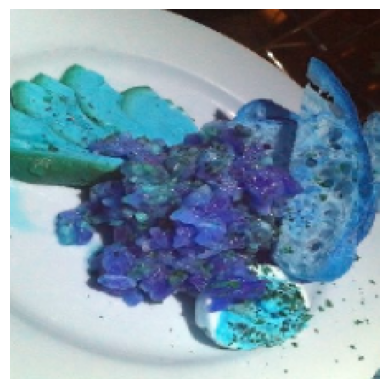

In [6]:
plt.axis(False)
t=train_ds.__getitem__(torch.randint(0,1000,(1,)))
print(t[0].shape)
plt.imshow(t[0].permute(1,2,0))
print(t[1])

In [7]:
torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [8]:
train_loader=torch.utils.data.DataLoader(train_ds,16,shuffle=True)
val_loader=torch.utils.data.DataLoader(test_ds,16,shuffle=True)

In [9]:
x,y=next(iter(train_loader))
print(x.shape)
output=torch.argmax(torch.softmax(model(x),dim=1),dim=1)
output

torch.Size([16, 3, 224, 224])


tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1])

In [10]:
y

tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])

In [11]:
loss_fn=nn.CrossEntropyLoss()

In [12]:
with torch.inference_mode():
    logits=model(x)
    torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),torch.argmax(y,dim=1)).sum().item()/len(logits)
    print(loss_fn(torch.squeeze(logits,dim=1),y))

tensor(0.6196)


In [13]:
model=model.to(device)

In [14]:
def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)

def train_model(model,epochs):
    optimizer=torch.optim.Adam(params=model.parameters())
    loss_fn=nn.CrossEntropyLoss()
    
    max_acc=0
    for i in tqdm_notebook(range(epochs)):
        train_preds=torch.tensor([])
        val_preds=torch.tensor([])
        train_actual=torch.tensor([])
        val_actual=torch.tensor([])
        
        print("\nTraining:")
        model.train()
        
        #Defining accuracy and loss for train and val data
        temp_train_accuracy=[]
        temp_val_accuracy=[]
        temp_train_loss=[]
        temp_val_loss=[]
        #temp_train_f1=[]
        #temp_val_f1=[]
    
        net_train_accuracy=0
        net_val_accuracy=0
        net_train_loss=0
        net_val_loss=0
        #net_train_f1=0
        #net_val_f1=0
        
        with tqdm_notebook(total=len(train_loader)) as pbar:
            for x,y in train_loader:
                    x=x.to(device)
                    y=y.to(device)
        
                    #Calculating model output
                    logits=model(x)
        
                    #Reseting any old gradient values
                    optimizer.zero_grad()
                    loss=loss_fn(torch.squeeze(logits,dim=1),y)
                
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    #train_preds=torch.hstack((train_preds,preds.to("cpu")))
                    #train_actual=torch.hstack((train_actual,y.to("cpu")))
                    accuracy_train=accuracy_fn(logits.type(torch.float32),torch.argmax(y,dim=1))
                    #f1_train=f1_fn(preds,y)
                    temp_train_accuracy.append(accuracy_train)
                    temp_train_loss.append(loss.item())
                    #temp_train_f1.append(f1_train.item())
                
                    #Back Propogation
                    loss.backward()
                
                    #Update Parameters
                    optimizer.step()
                
                    #Progress Bar Update
                    pbar.update(1)
            pbar.close()
        #Tensorboard & Metrics for the dataset
        net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
        net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
        #net_train_f1=sum(temp_train_f1)/len(temp_train_f1)
        #writer.add_scalar("Train Accuracy",net_train_accuracy,i)
        #writer.add_scalar("Train Loss",net_train_loss,i)
        #writer.add_scalar("Train F1 Score",net_train_f1,i)
    
        #Evaluation
        print("Testing:")
        model.eval()

        
    
        with tqdm_notebook(total=len(val_loader)) as pbar2:
            for x,y in val_loader:
                x=x.to(device)
                y=y.to(device)
                
                #Setting inference mode
                with torch.inference_mode():
                    logits=model(x)
                    loss=loss_fn(torch.squeeze(logits,dim=1),y.type(torch.float32))
                    
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    #val_preds=torch.hstack((val_preds,preds.to("cpu")))
                    #val_actual=torch.hstack((val_actual,y.to("cpu")))
                    accuracy_val=accuracy_fn(logits,torch.argmax(y,dim=1))
                    #f1_val=f1_fn(preds,y)
                    temp_val_accuracy.append(accuracy_val)
                    temp_val_loss.append(loss.item())
                    #temp_val_f1.append(f1_val.item())
    
                    #Progress Bar Update
                    pbar2.update(1)
            pbar2.close()
    
        #Tensorboard & Metrics for the dataset
        net_val_accuracy=sum(temp_val_accuracy)/len(temp_val_accuracy)
        net_val_loss=sum(temp_val_loss)/len(temp_val_loss)
        #net_val_f1=sum(temp_val_f1)/len(temp_val_f1)
        #writer.add_scalar("Val Accuracy",net_val_accuracy,i)
        #writer.add_scalar("Val Loss",net_val_loss,i)
        #writer.add_scalar("Val F1 Score",net_val_f1,i)

        if(net_val_accuracy>max_acc):
            max_acc=net_val_accuracy
            print(f'Saving model')
            torch.save(model.state_dict(),f'method2.pt')
        
        print(f"\nEpoch {i+1}:\n\nTrain Accuracy: {net_train_accuracy}\n\nTrain Loss: {net_train_loss}\n\nVal Accuracy: {net_val_accuracy}\n\nVal Loss: {net_val_loss}")



In [15]:
train_model(model,20)

  0%|          | 0/20 [00:00<?, ?it/s]


Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]

Saving model

Epoch 1:

Train Accuracy: 0.9811507936507936

Train Loss: 0.029451228745591328

Val Accuracy: 1.0

Val Loss: 0.0003100695762164292

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 2:

Train Accuracy: 1.0

Train Loss: 0.00034994315014465313

Val Accuracy: 1.0

Val Loss: 4.790475420085681e-07

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 3:

Train Accuracy: 0.9831349206349206

Train Loss: 0.046881753461927585

Val Accuracy: 0.5218253968253969

Val Loss: 46.225436044117764

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 4:

Train Accuracy: 0.998015873015873

Train Loss: 0.0042415050400916475

Val Accuracy: 1.0

Val Loss: 0.0

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 5:

Train Accuracy: 1.0

Train Loss: 5.74516490783504e-05

Val Accuracy: 1.0

Val Loss: 2.1287350577155833e-09

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 6:

Train Accuracy: 0.996031746031746

Train Loss: 0.009433053459339315

Val Accuracy: 1.0

Val Loss: 1.3417930327528995e-05

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 7:

Train Accuracy: 1.0

Train Loss: 6.899707025031008e-05

Val Accuracy: 1.0

Val Loss: 2.3840355264677304e-05

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 8:

Train Accuracy: 1.0

Train Loss: 1.7980192273253207e-05

Val Accuracy: 1.0

Val Loss: 2.415683028116309e-05

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 9:

Train Accuracy: 1.0

Train Loss: 1.8785641400549074e-05

Val Accuracy: 1.0

Val Loss: 2.230466869451455e-05

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 10:

Train Accuracy: 1.0

Train Loss: 1.0988420047406163e-05

Val Accuracy: 1.0

Val Loss: 4.633339889427104e-05

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 11:

Train Accuracy: 1.0

Train Loss: 2.435528641070351e-05

Val Accuracy: 1.0

Val Loss: 2.3318794226418003e-05

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 12:

Train Accuracy: 1.0

Train Loss: 2.3814621463238322e-05

Val Accuracy: 1.0

Val Loss: 1.960983021455739e-05

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 13:

Train Accuracy: 1.0

Train Loss: 4.6445503027344545e-06

Val Accuracy: 1.0

Val Loss: 6.301248378339855e-05

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 14:

Train Accuracy: 0.9990079365079365

Train Loss: 0.0023402528403268113

Val Accuracy: 1.0

Val Loss: 5.046376418119158e-05

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 15:

Train Accuracy: 1.0

Train Loss: 1.1733894477930539e-06

Val Accuracy: 1.0

Val Loss: 4.94064257894862e-06

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 16:

Train Accuracy: 1.0

Train Loss: 5.468259636068912e-07

Val Accuracy: 1.0

Val Loss: 3.5534557893675026e-05

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 17:

Train Accuracy: 1.0

Train Loss: 3.4460880709160627e-07

Val Accuracy: 1.0

Val Loss: 1.3488745008639208e-06

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 18:

Train Accuracy: 1.0

Train Loss: 1.460660108907436e-06

Val Accuracy: 1.0

Val Loss: 5.351046453346461e-07

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 19:

Train Accuracy: 1.0

Train Loss: 6.571150120263851e-07

Val Accuracy: 1.0

Val Loss: 3.765371627335096e-07

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 20:

Train Accuracy: 1.0

Train Loss: 6.195483269479834e-07

Val Accuracy: 1.0

Val Loss: 1.7615878672435443e-05


In [16]:
x,y=next(iter(val_loader))
x=x.to(device)
y=y.to(device)

In [17]:
with torch.inference_mode():
    output=torch.argmax(torch.softmax(model(x),dim=1),dim=1)
    print(output)

tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')


In [18]:
torch.argmax(y,dim=1)

tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')

In [19]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 5.844MB
